In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [65]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, fit, compute_metrics_region, load_model_experiment, plot_field_region, load_model_experiment_deeponet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Datasets

In [66]:
# input data shape (8400, 12)
# trunk shape (361 * 181, 2)
# target shape (8400, 361 * 181)

#input_data = np.random.randn(8400, 12)        
#trunk = np.random.randn(361 * 181, 2)        
#target = np.random.randn(8400, 361 * 181)

input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [67]:
from forecasting_analysis import create_windows_forecasting_with_index

In [68]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 1
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7640, 30, 12]) torch.Size([7640, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [69]:
# first_test_idx = np.where(test_mask)[0][0]
# print("First test target date:", tgt_dates[first_test_idx])
# print("Input window covers:",
#       dates[first_test_idx : first_test_idx + W])

In [70]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [71]:
scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [ ]:
# create datasets
train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## TRON

In [73]:
from helper import init_model, init_model_deeponet
from forecasting_analysis import train_model

In [74]:
tron_model = init_model()
deeponet_model = init_model_deeponet()

In [100]:
# history = train_model(
#     model=deeponet_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     scaler_target=scaler_target,
#     num_epochs=200,
#     lr=1e-3,
#     weight_decay=1e-4,
#     scheduler_step=20,
#     scheduler_gamma=0.7,
#     early_stop_patience=10,
#     save_path="analysis/forecasting/deeponet_forecast.pt"
# )

# history = train_model(
#     model=tron_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     scaler_target=scaler_target,
#     num_epochs=200,
#     lr=1e-3,
#     weight_decay=1e-3,
#     scheduler_step=20,
#     scheduler_gamma=0.7,
#     early_stop_patience=20,
#     save_path="analysis/forecasting/tron_forecast.pt"
# )

In [86]:
# save history
import pickle
#with open('analysis/forecasting/training_tron_history.pkl', 'wb') as f:
#    pickle.dump(history, f)

# how to load history
def load_history(path, plot=True):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        ax.plot(history['train_loss'], label='Train Loss')
        ax.plot(history['val_loss'], label='Validation Loss')
        ax.set_yscale('log')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training History')
        plt.show()
    else:
        return history

    return 0

history_deeponet = load_history('analysis/forecasting/training_deeponet_history.pkl', plot=False)
history_tron = load_history('analysis/forecasting/training_tron_history.pkl', plot=False)

In [98]:
#print(np.array(history_deeponet['train_loss']).min(), np.array(history_tron['val_loss']).min())
#print(np.array(history_tron['train_loss']).min(), np.array(history_tron['val_loss']).min())

In [135]:
model = load_model_experiment(model_path = 'analysis/forecasting/tron_forecast.pt')
#model = load_model_experiment_deeponet(model_path = 'analysis/forecasting/deeponet_forecast.pt')

outputs, targets = fit(model.to(device), test_loader, device, scaler_target)

Loaded model from analysis/forecasting/tron_forecast.pt


In [136]:
lon_grid, lat_grid, pred_img = convert2dim(outputs, grid_path='data/grid_points.npy')  # (N,H,W)
_,        _,        targ_img = convert2dim(targets, grid_path='data/grid_points.npy')  # (N,H,W)

print("Prediction image shape:", pred_img.shape)
print("Target image shape:", targ_img.shape)

Prediction image shape: (365, 181, 361)
Target image shape: (365, 181, 361)


In [137]:
l2, ssim = compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 0.8051191
Mean SSIM: 0.997752041560496


In [138]:
# 365 days covering 2023 test period
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

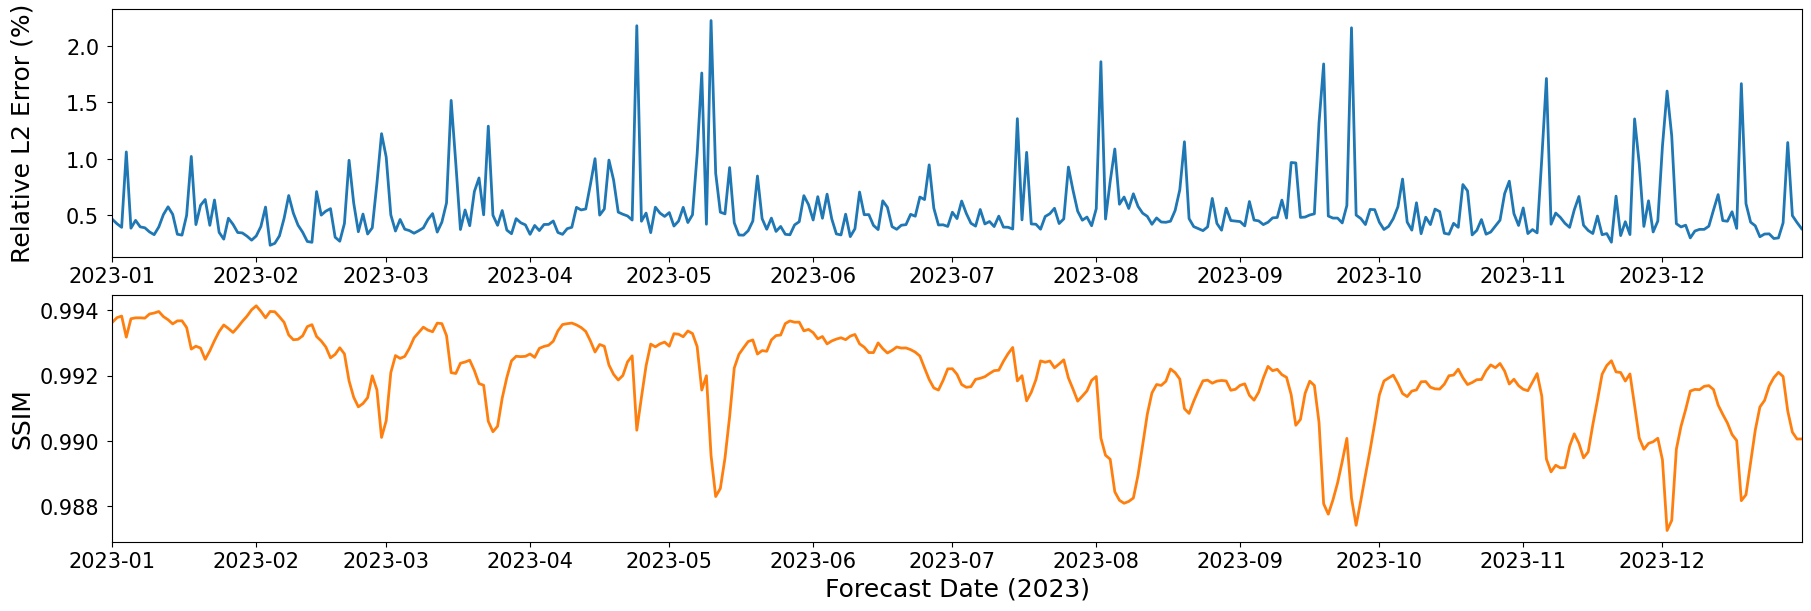

In [105]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True, constrained_layout=True)

# month ticks/labels (use '%b' for Jan/Feb..., or '%Y-%m' for 2023-01)
month_locator = mdates.MonthLocator(interval=1)
month_fmt = mdates.DateFormatter('%Y-%m')

# --- top: Relative L2 ---
ax[0].plot(dates, l2, lw=2, color='tab:blue')
ax[0].set_ylabel('Relative L2 Error (%)', fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# --- bottom: SSIM ---
ax[1].plot(dates, ssim, lw=2, color='tab:orange')
ax[1].set_ylabel('SSIM', fontsize=18)
ax[1].set_xlabel('Forecast Date (2023)', fontsize=18)
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# apply the SAME x tick locator/formatter to BOTH axes
for a in ax:
    a.xaxis.set_major_locator(month_locator)
    a.xaxis.set_major_formatter(month_fmt)
    # <-- CRUCIAL: re-enable top-axis labels even with sharex
    a.tick_params(axis='x', which='both', labelbottom=True, rotation=0)
    a.yaxis.set_ticks_position('left')
    a.yaxis.set_label_position('left')
    a.tick_params(axis='y', pad=6)
    # thick font size for x and y ticks
    a.tick_params(axis='x', labelsize=15)
    a.tick_params(axis='y', labelsize=15)

# nice alignment and limits
fig.align_ylabels(ax)
ax[1].set_xlim(dates[0], dates[-1])

#plt.savefig('analysis/forecasting/forecast_metrics_2023.png', dpi=300)
plt.show()


In [139]:
# find 50th percentile dates for L2 and SSIM
l2_50th = np.percentile(l2, 50)
ssim_50th = np.percentile(ssim, 50)

idx_50pct = np.argmin(np.abs(l2 - l2_50th))
idx_50pct_ssim = np.argmin(np.abs(ssim - ssim_50th))

print("50th percentile Relative L2 Error: %.2f%% on %s" % (l2_50th, dates[idx_50pct].strftime('%Y-%m-%d')))
print("50th percentile SSIM: %.4f on %s" % (ssim_50th, dates[idx_50pct_ssim].strftime('%Y-%m-%d')))

# find the minimum ssim
min_ssim_idx = np.argmin(ssim)
print("Minimum SSIM: %.4f on %s" % (ssim[min_ssim_idx], dates[min_ssim_idx].strftime('%Y-%m-%d')))

50th percentile Relative L2 Error: 0.63% on 2023-08-30
50th percentile SSIM: 0.9979 on 2023-08-01
Minimum SSIM: 0.9932 on 2023-05-11


In [125]:
date = dates[min_ssim_idx]

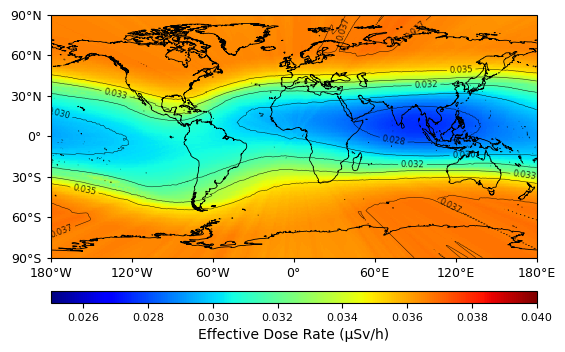

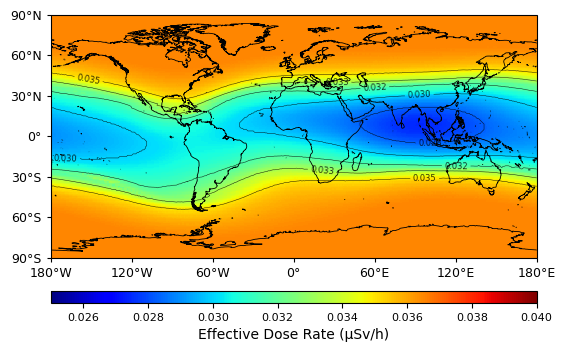

In [117]:
# convert index to date
date = dates[idx_50pct].date()

plot_field_region(
    lon_grid, lat_grid, pred_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/prediction_global.png'
)

plot_field_region(
    lon_grid, lat_grid, targ_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/target_global.png'
)

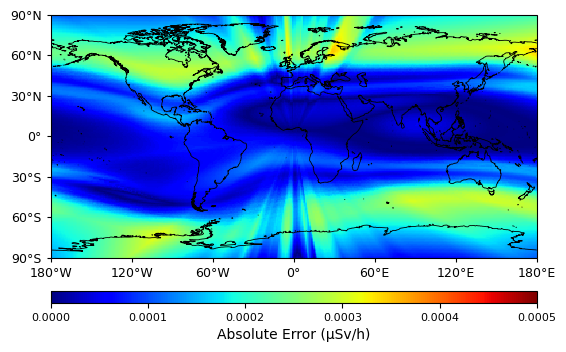

In [140]:
plot_field_region(
    lon_grid, lat_grid, np.abs((targ_img - pred_img)), i=idx_50pct_ssim,
    #title=f"test {date} - Error Map",
    units_label="Absolute Error (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0, vmax=5E-4,
    tick_step=(60, 30),
    #add_contour=True, contour_levels=np.linspace(0.025, 0.040, 5),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/tron_error_global_50thpct.png'
)